In [1]:
import os
import pickle
import torch
import nb_utils
from lightning_data_modules import HaarDecomposedDataset, ImageDatasets, PairedDataset, SyntheticDataset, SyntheticPairedDataset, Synthetic1DConditionalDataset, SyntheticTimeSeries, SRDataset, SRFLOWDataset, KSphereDataset, MammothDataset, LineDataset, GanDataset #needed for datamodule registration
import torch
import numpy as np
import matplotlib.pyplot as plt
from lightning_modules.KSphereGroundTruthModel import KSphereGroundTruthModel
from models.ksphere_gt import KSphereGT
from models.ddpm import DDPM
from models.fcn import FCN
import pickle
import sde_lib
from dim_reduction import get_manifold_dimension

/store/CIA/js2164/conda_envs/score_sde/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Moving cwd to /store/CIA/js2164/repos/diffusion/score_sde_pytorch


In [2]:
log_path = 'logs/ksphere/n_1/dim_50/random_isometry'
log_name = 'uniform_random'

In [10]:
config_path = os.path.join(log_path, log_name, 'config.pkl')
with open(config_path, 'rb') as file:
    config = pickle.load(file)
#config.model.checkpoint_path = $os.path.join(log_path, log_name, "checkpoints/best/last.ckpt")
config.model.checkpoint_path = 'logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt'
config.logging.log_path = log_path
config.logging.log_name = log_name

config.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
config.training.batch_size=32
config.dim_estimation.num_datapoints=5

In [11]:
import torch 
from pathlib import Path
import os
from lightning_modules.utils import create_lightning_module
from lightning_data_modules.utils import create_lightning_datamodule
from models import utils as mutils
import math
from tqdm import tqdm
import pickle

#---- create the setup ---
def robust(config, noise=0):
  log_path = config.logging.log_path
  log_name = config.logging.log_name
  save_path = os.path.join(log_path, log_name, 'svd')
  Path(save_path).mkdir(parents=True, exist_ok=True)

  DataModule = create_lightning_datamodule(config)
  DataModule.setup()
  train_dataloader = DataModule.train_dataloader()
    
  pl_module = create_lightning_module(config)
  pl_module = pl_module.load_from_checkpoint(config.model.checkpoint_path)
  pl_module.configure_sde(config)

  #get the ema parameters for evaluation
  #pl_module.ema.store(pl_module.parameters())
  #pl_module.ema.copy_to(pl_module.parameters()) 

  device = config.device
  pl_module = pl_module.to(device)
  pl_module.eval()
  
  score_model = pl_module.score_model
  sde = pl_module.sde
  score_fn = mutils.get_score_fn(sde, score_model, conditional=False, train=False, continuous=True)
  #---- end of setup ----

  num_datapoints = 2
  singular_values = []
  normalized_scores_list = []
  idx = 0
  with tqdm(total=num_datapoints) as pbar:
    for _, orig_batch in enumerate(train_dataloader):

      orig_batch = orig_batch.to(device)
      batchsize = orig_batch.size(0)
      
      if idx+1 >= num_datapoints:
          break
        
      for x in orig_batch:
        if idx+1 >= num_datapoints:
          break
        
        ambient_dim = math.prod(x.shape[1:])
        x = x.repeat([batchsize,]+[1 for i in range(len(x.shape))])

        num_batches = ambient_dim // batchsize + 1
        extra_in_last_batch = ambient_dim - (ambient_dim // batchsize) * batchsize
        num_batches *= 8

        t = pl_module.sampling_eps
        vec_t = torch.ones(x.size(0), device=device) * t

        scores = []
        for i in range(1, num_batches+1):
          batch = x.clone()

          mean, std = sde.marginal_prob(batch, vec_t)
          z = torch.randn_like(batch)
          batch = mean + std[(...,) + (None,) * len(batch.shape[1:])] * z
          score = score_fn(batch, vec_t).detach().cpu()

          if i < num_batches:
            scores.append(score)
          else:
            scores.append(score[:extra_in_last_batch])
        
        scores = torch.cat(scores, dim=0)
        scores = torch.flatten(scores, start_dim=1)

        means = scores.mean(dim=0, keepdim=True)
        normalized_scores = scores - means
        #corrupt
        norm = torch.linalg.norm(normalized_scores, dim=1).mean()
        corruption = noise * norm * torch.randn_like(normalized_scores) / np.sqrt(normalized_scores.shape[1])
        corruption_norm = torch.linalg.norm(corruption, dim=1).mean()
        print(f'score norm: {norm}, corruption norm: {corruption_norm}')
        normalized_scores = corruption + normalized_scores
        
        #normalized_scores_list.append(normalized_scores.tolist())

        u, s, v = torch.linalg.svd(normalized_scores)
        s = s.tolist()
        singular_values.append(s)

        idx+=1
        pbar.update(1)
    return singular_values

In [12]:
stds = np.linspace(0, 1, 20)
r = []
for std in stds:
    singular_values = robust(config, noise=std)[0]
    r.append(singular_values)

Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  1.36it/s]

score norm: 661.3070678710938, corruption norm: 0.0



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.79it/s]

score norm: 667.7528076171875, corruption norm: 35.16044616699219



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.58it/s]

score norm: 651.4771118164062, corruption norm: 68.70538330078125



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.50it/s]

score norm: 664.067626953125, corruption norm: 104.01919555664062



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.74it/s]

score norm: 643.7341918945312, corruption norm: 135.67864990234375



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.67it/s]

score norm: 649.1931762695312, corruption norm: 170.1087646484375



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.77it/s]

score norm: 646.8887329101562, corruption norm: 203.8316650390625



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.71it/s]

score norm: 636.8121948242188, corruption norm: 232.81588745117188



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.72it/s]

score norm: 659.9848022460938, corruption norm: 275.1959533691406



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.72it/s]

score norm: 646.5913696289062, corruption norm: 304.1991271972656



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.35it/s]

score norm: 670.1339111328125, corruption norm: 351.6878967285156



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.52it/s]

score norm: 645.39208984375, corruption norm: 373.74664306640625



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.56it/s]

score norm: 660.63427734375, corruption norm: 416.5083923339844



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.71it/s]

score norm: 660.2705688476562, corruption norm: 451.7660827636719



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.40it/s]

score norm: 662.0341796875, corruption norm: 486.56201171875



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.61it/s]

score norm: 659.4730834960938, corruption norm: 518.728271484375



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.01it/s]

score norm: 643.4620361328125, corruption norm: 540.904052734375



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.29it/s]

score norm: 665.859375, corruption norm: 594.0006713867188



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.71it/s]

score norm: 667.8997802734375, corruption norm: 633.681884765625



Lightning automatically upgraded your loaded checkpoint from v1.5.1 to v1.9.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint --file logs/ksphere/n_1/dim_50/random_isometry/uniform_random/checkpoints/best/epoch=13952--eval_loss_epoch=128.853.ckpt`
 50%|█████     | 1/2 [00:00<00:00,  4.69it/s]

score norm: 644.0001831054688, corruption norm: 638.4680786132812


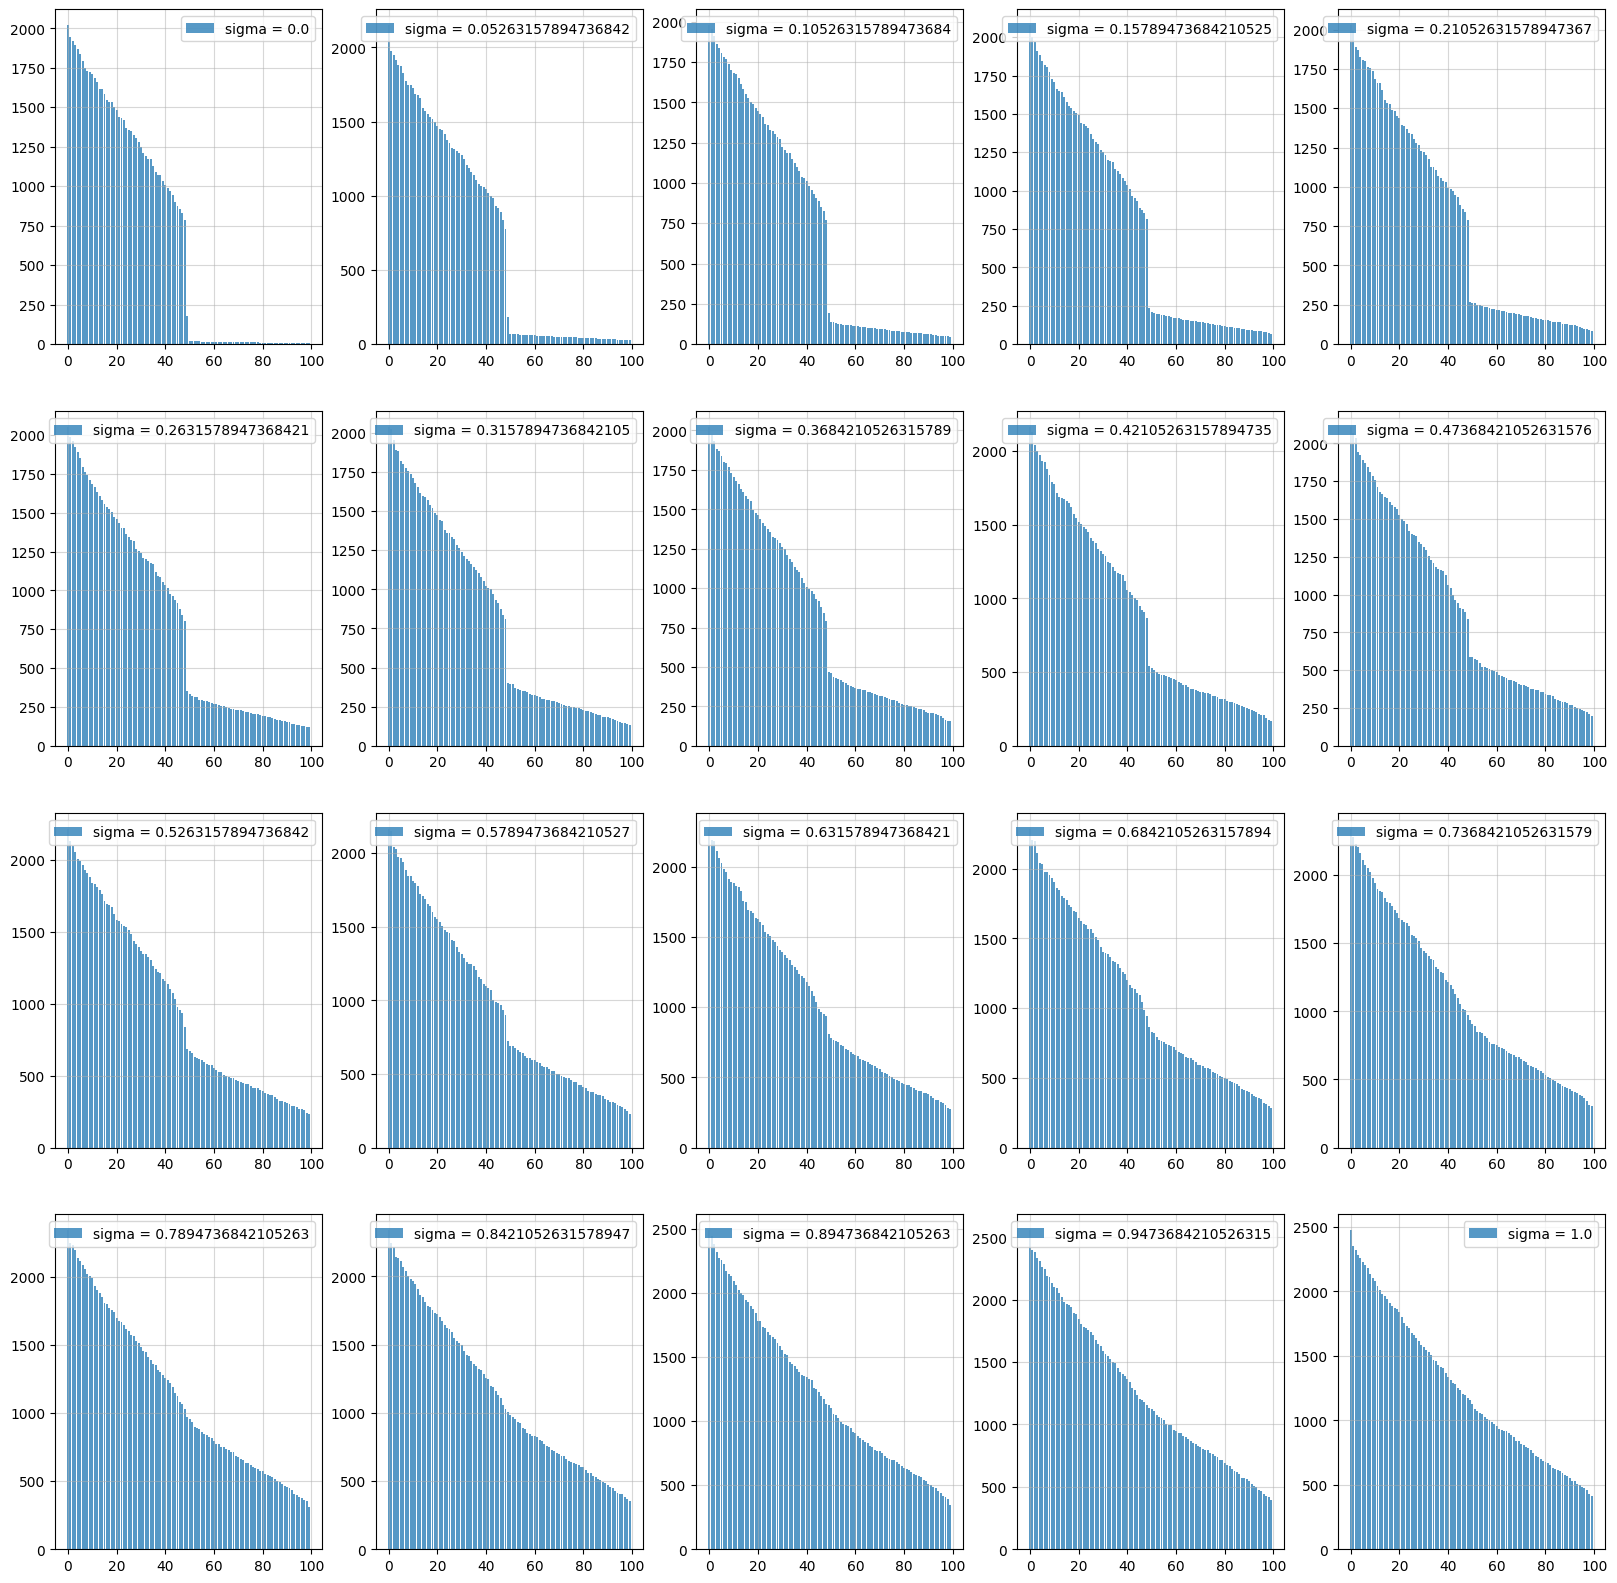

In [13]:
fig, axes = plt.subplots(4, 5,figsize=(20,20))
axes = axes.flatten()
#ax.rcParams.update({'font.size': 16})

for i, (std, s) in enumerate(zip(stds, r)):
    axes[i].grid(alpha=0.5)
    axes[i].bar(range(len(s)), s, label=f'sigma = {std}', alpha=0.75)
    axes[i].legend()
#plt.xticks(range(0, 100, 5))
#plt.vlines(95, 0, np.max(s), color='r', linestyles='--')
#plt.vlines(70, 0, np.max(s), color='r', linestyles='--')
fig.show()

In [14]:
def softmax(x):
        """Compute softmax values for each sets of scores in x."""
        e_x = np.exp(x - np.max(x))
        return e_x / e_x.sum(axis=0) # only difference

In [15]:
dims = []
for i, (std, s) in enumerate(zip(stds, r)):
    norm_factor = s[1]-s[2]
    diff = [(s[i]-s[i+1])/norm_factor for i in range(1, len(s)-1)]
    soft = softmax(diff)
    dims.append(len(soft) - soft.argmax())

In [16]:
dims

[51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 51,
 97,
 75,
 89,
 97,
 97,
 93,
 92]

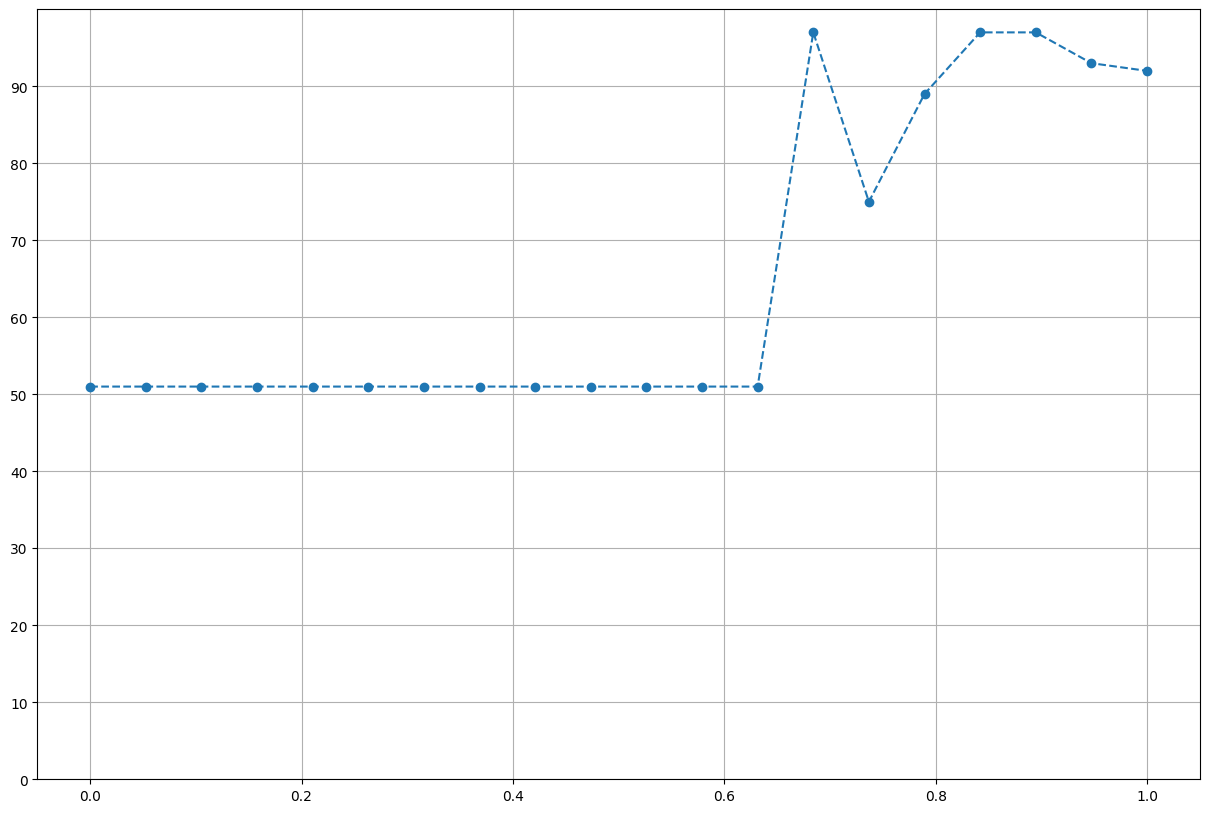

In [19]:
plt.figure(figsize=(15,10))
plt.plot(stds, dims, 'o--')
plt.ylim(0,100)
plt.yticks(range(0,100,10))
plt.grid()